# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [2]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline

## Least squares

One more time, let's load up the NSFG data.

In [4]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

The following function computes the intercept and slope of the least squares fit.

In [5]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [6]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.8303969733110526, 0.017453851471802756)

In [7]:
# Mine
regress_results = stats.linregress(ages, weights)
regress_results

LinregressResult(slope=0.017453851471802746, intercept=6.830396973311053, rvalue=0.06883397035410904, pvalue=5.7229471073149905e-11, stderr=0.0026611480116264744)

In [8]:
# Try with statsmodels too
x = ages.values
y = weights.values
x2 = sm.add_constant(x)

OLSresult = sm.OLS(y, x2).fit()

In [9]:
OLSresult.params # gives intercept and slope

array([6.83039697, 0.01745385])

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [10]:
inter + slope * 25

7.2667432601061215

And the slope is easier to interpret if we express it in pounds per decade (or ounces per year).

In [11]:
slope * 10

0.17453851471802756

The following function evaluates the fitted line at the given `xs`.

In [12]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [13]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

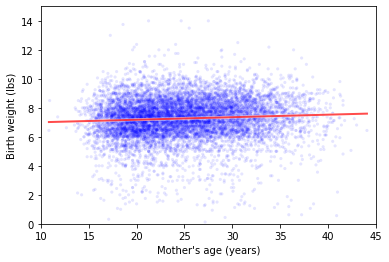

In [14]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

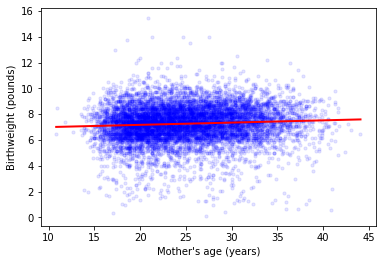

In [15]:
# Mine
fig,ax = plt.subplots()

ax.scatter(ages, weights, s=10, c='blue', alpha=0.1)
ax.plot(fit_xs, fit_ys, color='red', linewidth=2)

ax.set_xlabel('Mother\'s age (years)')
ax.set_ylabel('Birthweight (pounds)')

plt.show()

## Residuals

The following functon computes the residuals.

In [16]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [17]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [18]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [19]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [20]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

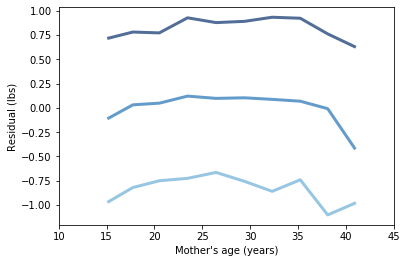

In [21]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

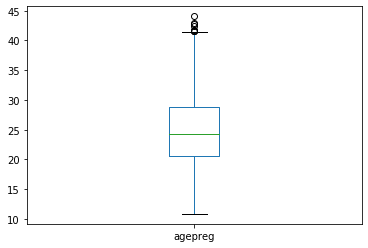

In [22]:
# Mine
# Just use the residuals already added to the df and pd.cut
# If I was really doing this I would first use a box plot to see the distribution of the data
# I need to use a range that includes all the data or I would get nans
live.agepreg.plot(kind='box')

In [23]:
live['agebin'] = pd.cut(live.agepreg, bins = range(10,48,3))
live.agebin.value_counts().sum()

9038

In [24]:
# Create data for the plot: for each bin, compute the average age and create rvs for the ages
live_grouped = live.groupby('agebin')
bin_age_averages = live_grouped.agepreg.mean().values[1:-1] # Remove the two end groupings as they are just small numbers of outliers

In [25]:
def DiscreteRv(a):
    """Creates a scipy.stats discrete_rv.

    Arguments:
        a {array-like} -- a single data set, will be flattened if it is not already 1-D

    Returns:
        An instance of scipy.stats discrete_rv representing the input data
    """
    val,cnt = np.unique(a, return_counts=True)
    
    return stats.rv_discrete(values=(val,cnt/sum(cnt)))

In [26]:
# Groupby objects are tuples that have an index in the first part and the data in the second part
# Can access the data with as loop using a variable for the second part of the tuple
# I'm plotting the age averages vs the percentiles for the cdfs of the residuals
rvs = []

for i,data in live_grouped:
    rvs.append(DiscreteRv(data.residual))
    
rvs = rvs[1:-1] # Remove the two end groupings as they are just small numbers of outliers

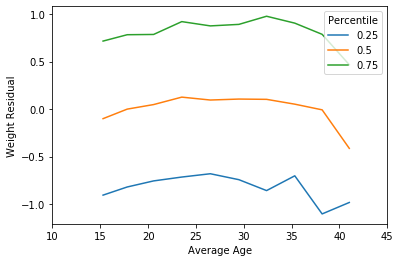

In [27]:
# Now plot using the percentiles
percentiles = [.25,.50,.75]

fig,ax = plt.subplots()

for p in percentiles:
    cdfs_at_p = [rv.ppf(p) for rv in rvs]
    ax.plot(bin_age_averages, cdfs_at_p, label= p)

plt.xlim(10,45)
plt.xlabel('Average Age')
plt.ylabel('Weight Residual')
plt.legend(title='Percentile', loc='upper right')
plt.show()

## Sampling distribution

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

In [28]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [29]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [30]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [31]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [32]:
Summarize(inters)

mean, SE, CI 6.8311943511163244 0.0699866683108296 (6.714821740271296, 6.94781860926733)


And for `slope`.

In [33]:
Summarize(slopes)

mean, SE, CI 0.017382665124024484 0.002757477140184835 (0.012787521088655237, 0.02214811615026807)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [34]:
# Mine, repeating above using pandas sample and scipy
# This is using resampling, also called bootstrapping
my_iters = 101
my_inters = []
my_slopes = []
for _ in range(my_iters):
    my_sample = live.sample(n=len(live), replace=True)
    my_ages = my_sample.agepreg
    my_weights = my_sample.totalwgt_lb
    regress_result = stats.linregress(my_ages, my_weights)
    my_inters.append(regress_result.intercept)
    my_slopes.append(regress_result.slope)

In [35]:
# Intercept results
# Can't use the DescrStatsW confidence interval method because these values are for a sampling distribution
# Need to use discrete rv instead
inter_rv = DiscreteRv(my_inters)
confint = inter_rv.interval(.90) # 90% confidence interval
inter_rv.mean(), inter_rv.std(), confint

(6.826373736947123,
 0.07391567004815372,
 (6.720499336085283, 6.943270849730652))

In [36]:
# Slope results
# Can't use the DescrStatsW confidence interval method because these values are for a sampling distribution
# Need to use discrete rv instead
slope_rv = DiscreteRv(my_slopes)
confint = slope_rv.interval(.90) # This is a confidence interval about the median
slope_rv.mean(), slope_rv.std(), confint

(0.017626500704001884,
 0.0029508409233863666,
 (0.012879777568372434, 0.02184796171425712))

In [37]:
# The above confidence interval method is the same as using the ppf method of the discrete rv
# This method works because we are already looking at a sampling distribution and we can just take 90% of it
conf_int_ppf = slope_rv.ppf(.05), slope_rv.ppf(.95)
conf_int_ppf

(0.012879777568372434, 0.02184796171425712)

In [38]:
# Try above using statsmodels OLS instead (I think this is a parametric way but need to check the implementation)

In [39]:
x = ages.values
y = weights.values
x2 = sm.add_constant(x)

OLSresult = sm.OLS(y, x2).fit()

In [40]:
OLSresult.params # intercept and slope

array([6.83039697, 0.01745385])

In [41]:
OLSresult.conf_int(alpha=.1) # works perfectly to make confidence intervals for the intercept and slope

array([[6.71856081, 6.94223314],
       [0.0130762 , 0.0218315 ]])

In [42]:
# Try the exercise given too: generate a list of estimates for the mean birth weight, compute the SE and CI for these estimates
my_iters = 101
my_means = []
for _ in range(my_iters):
    my_sample2 = live.sample(n=len(live), replace=True)
    weight_mean = my_sample2.totalwgt_lb.mean()
    my_means.append(weight_mean)

In [43]:
wgt_rv = DiscreteRv(my_means)
wgt_confint = wgt_rv.interval(.90)
wgt_rv.std(), wgt_confint

(0.014713712889098238, (7.238686656339898, 7.291505310909494))

## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

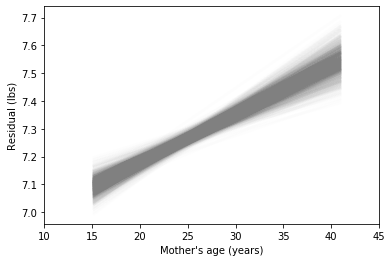

In [44]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [45]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

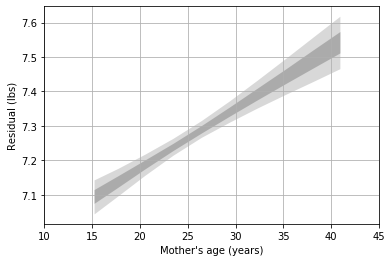

In [46]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

plt.grid()

In [47]:
# Try doing this in seaborn
import seaborn as sns

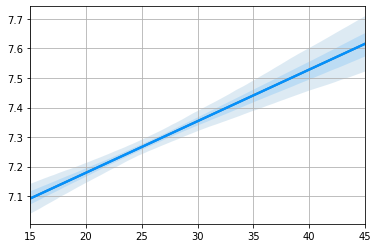

In [48]:
# Got it to work
plt.xlim(15,45) # Need to add this because without it the x-value range only shows from about 20 to 30
sns.regplot(x=ages.values, y=weights.values, scatter=False, ci=90)
sns.regplot(x=ages.values, y=weights.values, scatter=False, ci=50, color='#0390fc')

plt.grid()

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [49]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [50]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710369

In [51]:
# Can use OLS results from above
OLSresult.rsquared

0.004738115474710591

In [52]:
# Or linregress results
regress_results

LinregressResult(slope=0.017453851471802746, intercept=6.830396973311053, rvalue=0.06883397035410904, pvalue=5.7229471073149905e-11, stderr=0.0026611480116264744)

In [53]:
regress_results.rvalue**2

0.004738115474710362

We can confirm that $R^2 = \rho^2$:

In [54]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410907
R 0.0688339703541091


In [55]:
np.sqrt(OLSresult.rsquared), regress_results.rvalue

(0.06883397035411071, 0.06883397035410904)

To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [56]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.40821553384062
Std(res) 1.4048754287857834


In [57]:
# Mine
weights.std(), res.std()

(1.4082934455690168, 1.4048754287857832)

As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [58]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [59]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

And it is.

In [60]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

In [61]:
# Mine, I can get a p-value from the OLS or linregress results
OLSresult.pvalues, regress_results.pvalue

(array([0.00000000e+00, 5.72294711e-11]), 5.7229471073149905e-11)

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [62]:
ht.actual, ht.MaxTestStat()

(0.017453851471802756, 0.009174759413445564)

We can also use resampling to estimate the sampling distribution of the slope.

In [63]:
sampling_cdf = thinkstats2.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

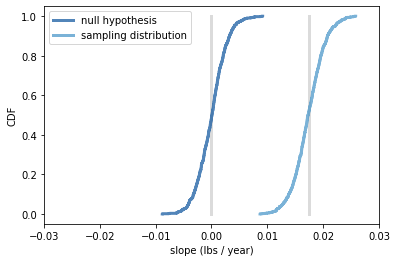

In [64]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

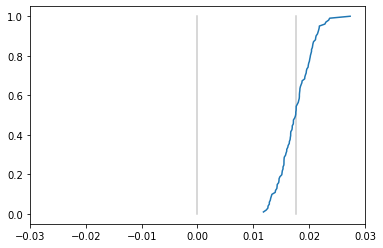

In [65]:
# Mine, using my slope rv from above, left out cdf for null hypothesis because I didn't compute it
fig,ax = plt.subplots()

ax.plot([0, 0], [0, 1], color='0.8')

ax.plot([slope_rv.mean(), slope_rv.mean()], [0, 1], color='0.8')
ax.plot(slope_rv.xk, slope_rv.cdf(slope_rv.xk))

plt.xlim(-.03, .03)

plt.show()

Here's how to get a p-value from the sampling distribution.

In [66]:
pvalue = sampling_cdf[0]
pvalue

0

In [67]:
# Mine
slope_rv.cdf(0)

0.0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [68]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [69]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.351303800619607 0.012931398134443472 (7.330942963044921, 7.374142509404735)


And here's what the same calculation looks like if we ignore the weights.

In [70]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.267484371542377 0.015443365115231165 (7.24297410931622, 7.294029375968135)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.

In [71]:
# Mine, I think I can just sample the dataFrame using the sample method and including finalwgt as the weights, like below
my_wgt_sample = live.sample(n=len(live), replace=True, weights=live.finalwgt)

In [72]:
# First with weights
my_iters2 = 101
my_estimates2 = [live.sample(n=len(live), replace=True, weights=live.finalwgt).totalwgt_lb.mean() 
                 for x in range(my_iters2)]

In [73]:
# Weighted summary
est2_summary = sm.stats.DescrStatsW(my_estimates2)
wgt_rv2 = DiscreteRv(my_estimates2)
wgt_confint2 = wgt_rv2.ppf(0.5), wgt_rv2.ppf(0.95)
est2_summary.mean, est2_summary.std, wgt_confint2

(7.350035753879659,
 0.013788092392603165,
 (7.349475824297411, 7.372897764992255))

In [74]:
# Then without weights
my_iters3 = 101
my_estimates3 = [live.sample(n=len(live), replace=True).totalwgt_lb.mean() 
                 for x in range(my_iters3)]

In [75]:
# Non-weighted summary
est3_summary = sm.stats.DescrStatsW(my_estimates3)
wgt_rv3 = DiscreteRv(my_estimates3)
wgt_confint3 = wgt_rv3.ppf(0.5), wgt_rv3.ppf(0.95)
est3_summary.mean, est3_summary.std, wgt_confint3

(7.266873681310375,
 0.01532109839958097,
 (7.269867503872538, 7.290945175923877))

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [76]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [77]:
# Solution goes here
brfss_ls = stats.linregress(log_weights, heights)
print('slope =',f'{brfss_ls.slope:.2f}', 'inter =', f'{brfss_ls.intercept:.2f}')

slope = 53.53 inter = 68.02


Make a scatter plot of the data and show the fitted line.

Text(0.2, -70, 'Hello')

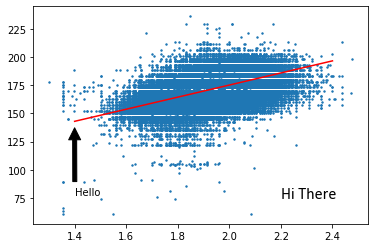

In [115]:
# Using matplotlib
fxs, fys = FitLine([1.4,2.4], brfss_ls.intercept, brfss_ls.slope)

fig,ax = plt.subplots()

ax.scatter(log_weights, heights, s=2)
ax.plot(fxs, fys, c='red')

# Just trying out some font/text stuff
font = {'family': 'serif',
        'name': 'calibri',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
ax.text(2.2,75, "Hi There", fontdict=font)

# Try an annotation
ax.annotate("Hello",
            xy=(1.4, 140), xycoords='data',
            xytext=(.2, -70), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [80]:
# Using seaborn
# sns.regplot(log_weights, heights, scatter_kws={'s':2})

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

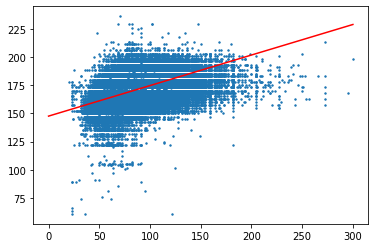

In [81]:
# Solution goes here
inv_weights = 10**log_weights
inv_brfss_ls = stats.linregress(inv_weights, heights)

inv_fxs, inv_fys = FitLine([0,300], inv_brfss_ls.intercept, inv_brfss_ls.slope)

fig,ax = plt.subplots()

ax.scatter(inv_weights, heights, s=2)
ax.plot(inv_fxs, inv_fys, c='red')

Plot percentiles of the residuals.

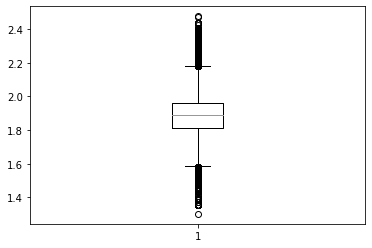

In [82]:
# Solution goes here: need to bin the log_weights
# First just try a box plot to see what the data looks like

fig,ax = plt.subplots()
ax.boxplot(log_weights)
plt.show()

In [83]:
# Build a function that produces means and residual percentiles for plotting

def ResidualPercentilePlotData(x, y, n_bins=10):
    # Calculate the intercept and slope of data
    linreg_result = stats.linregress(x, y)
    inter = linreg_result.intercept
    slope = linreg_result.slope
    
    # Calculate the residuals for each data point
    res = Residuals(x, y,inter, slope)
    
    # Bin the x data
    bins = np.linspace(min(x), max(x), num=n_bins)
    x_bins = pd.cut(x, bins)
    
    # Build a DataFrame to hold everything
    res_df = pd.DataFrame({'x':x, 'y':y, 'res':res, 'x_bins':x_bins})
    
    # Group the data by bins
    res_df_grouped = res_df.groupby('x_bins')
    
    # Get the mean of x for each bin
    x_means = res_df_grouped.x.mean().values
    
    # Build an rv of residual data for each bin
    res_rvs = np.array([DiscreteRv(data.res) for x,data in res_df_grouped])
    
    return x_means, res_rvs

In [84]:
x_means, res_rvs = ResidualPercentilePlotData(log_weights, heights, n_bins=8)

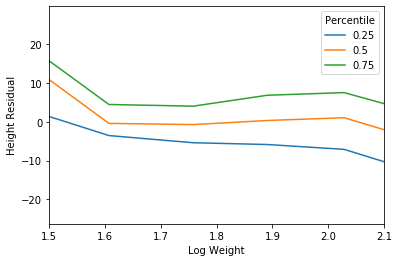

In [85]:
# Plot percentiles
percentiles = [.25,.50,.75]

fig,ax = plt.subplots()

for p in percentiles:
    cdfs_at_p = [rv.ppf(p) for rv in res_rvs]
    ax.plot(x_means, cdfs_at_p, label= p)

plt.xlim(1.5, 2.1)
plt.xlabel('Log Weight')
plt.ylabel('Height Residual')
plt.legend(title='Percentile', loc='upper right')
plt.show()

Compute correlation.

In [86]:
# Solution goes here
brfss_ls.rvalue

0.5317282605983443

Compute coefficient of determination.

In [87]:
# Solution goes here
brfss_ls.rvalue**2

0.28273494311894076

Confirm that $R^2 = \rho^2$.

In [88]:
# Solution goes here
# already done

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [89]:
# Solution goes here
heights.std()

10.390752100277956

Compute Std(res), the RMSE of predictions that do use height.

In [90]:
# Solution goes here
heights_res = Residuals(log_weights, heights, brfss_ls.intercept, brfss_ls.slope)
heights_res.std()

8.800072942334882

How much does height information reduce RMSE?

In [91]:
# Solution goes here
# by about 15%
(heights.std() - heights_res.std()) / heights.std()

0.1530860463796959

Use resampling to compute sampling distributions for inter and slope.

In [92]:
# Build a function to get intercept and slope sampling distributions

def ResampleInterSlope(x, y, iters=100):
    
    # Make a DataFrame to hold the two sequences
    df = pd.DataFrame({'x':x, 'y':y})
    
    # Initialize intercept and slope lists
    inters = []
    slopes = []
    
    # Resample the DataFrame and build lists of intercepts and slopes which are the sampling distributions
    for i in range(iters):
        sample = df.sample(n=len(df), replace=True)
        x_sample = sample.x
        y_sample = sample.y
        regress_result = stats.linregress(x_sample, y_sample)
        inters.append(regress_result.intercept)
        slopes.append(regress_result.slope)
    
    return inters, slopes

In [93]:
brfss_inters, brfss_slopes = ResampleInterSlope(log_weights, heights)

In [94]:
brfss_slopes

[53.66998654305727,
 53.71906020336702,
 53.44834171376287,
 53.769897163010626,
 53.50087041275462,
 53.443681976007106,
 53.52091452978844,
 53.80374916621436,
 53.50970533572923,
 53.64763052464379,
 53.4252269555076,
 53.62106936096573,
 53.69708634778413,
 53.52069901036036,
 53.6099450614097,
 53.295574928427136,
 53.539034749863475,
 53.62714141398239,
 53.61065584156001,
 53.32563498293897,
 53.67926790364023,
 53.23993851291976,
 53.56012275085804,
 53.595017667105466,
 53.409730223577476,
 53.52523549812928,
 53.33243613138599,
 53.534651720692636,
 53.731326605726096,
 53.42496393070903,
 53.424940117176305,
 53.64474684408391,
 53.33273021439598,
 53.20315416548775,
 53.49885615985105,
 53.394942755221955,
 53.5693045840881,
 53.61672081631796,
 53.50225822512983,
 53.603056788596156,
 53.73721204881162,
 53.55547198117974,
 53.44384544872065,
 53.588054143589396,
 53.238390282482435,
 53.5364640898472,
 53.49376969951782,
 53.534594513834456,
 53.39435088911546,
 53.300598

Plot the sampling distribution of slope.

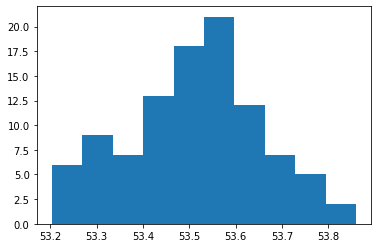

In [95]:
# Solution goes here
fig,ax = plt.subplots()

ax.hist(brfss_slopes)

plt.show()

In [96]:
# Create an rv and plot the cdf showing a line for mean of slopes
brfss_slopes_rv = DiscreteRv(brfss_slopes)
slopes_mean = brfss_slopes_rv.mean()

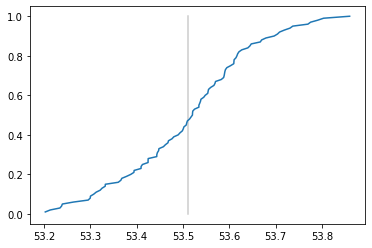

In [97]:
fig,ax = plt.subplots()

# ax.plot([0,0], [0,1], c='.8')
ax.plot([slopes_mean,slopes_mean], [0,1], c='.8')
ax.plot(brfss_slopes_rv.xk, brfss_slopes_rv.cdf(brfss_slopes_rv.xk))

plt.show()

Compute the p-value of the slope.

In [98]:
# Solution goes here: to do this need to compute how often the estimated slope falls below zero
brfss_slopes_rv.cdf(0)

0.0

In [99]:
# Reminder: ppf is the inverse of the cdf
brfss_slopes_rv.ppf(.5), brfss_slopes_rv.cdf(53.5)

(53.52069901036036, 0.4200000000000002)

Compute the 90% confidence interval of slope.

In [100]:
# Solution goes here
brfss_slopes_rv.interval(.9)

(53.23993851291976, 53.73721204881162)

Compute the mean of the sampling distribution.

In [101]:
# Solution goes here
brfss_slopes_rv.mean()

53.51169451450318

Compute the standard deviation of the sampling distribution, which is the standard error.

In [102]:
# Solution goes here
brfss_slopes_rv.std()

0.1414446826995977

Resample rows without weights, compute mean height, and summarize results.

In [103]:
# Build a resampling function that builds a list of mean estimates
def ResampleMean(data, weights=None, iters=100):
     
    # Resample with replacement, calculating the mean of the data and building a list of mean estimates
    if weights is None:   # In case of no weights, use a Series
        s = pd.Series(data)
        mean_estimates = [s.sample(n=len(s), replace=True).mean() for _ in range(iters)]
    
    else:    # In case of weights use a DataFrame
        df = pd.DataFrame({'data':data,'wgt':weights})
        mean_estimates = [df.sample(n=len(df), replace=True, weights=df.wgt).data.mean() for _ in range(iters)]
    
    return mean_estimates

In [104]:
# Build a summarize estimates function that returns summary statistics on parameter estimates
def SummarizeEstimates(estimates, alpha=0.90):
    """Computes the mean, standard deviation (std error), and a confidence interval for a sampling distribution (estimates).

    Args:
        estimates (array-like): A sequence of estimates for a statistic obtained from resampling (sampling distribution)
        alpha (float): Probability for the confidence interval. Must be between 0 and 1. Defaults to 0.90.

    Returns:
        mean: mean value of the estimates
        std: standard deviation of the estimates (std error)
        confidence interval: interval about the median of the distribution
    """
    rv = DiscreteRv(estimates)
    return np.mean(estimates), np.std(estimates), rv.interval(alpha)

In [105]:
# Solution goes here
hgt_est = ResampleMean(heights)

In [106]:
SummarizeEstimates(hgt_est)

(168.95437895369753,
 0.01459771009031973,
 (168.92926544594675, 168.98474100123283))

Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [107]:
# Solution goes here
hgt_est_weighted = ResampleMean(heights, weights=df.finalwt)

In [108]:
SummarizeEstimates(hgt_est_weighted)

(170.49624663998873,
 0.017169793445189235,
 (170.46417166878877, 170.52098870227775))

In [109]:
# My work above appears to be correct, but the author uses the variables in theopposite order in solutions:
# x = height and y = weight

In [110]:
# Messing around with statsmodels.stats.weightstats.DescrStatsW
var = sm.stats.DescrStatsW(ages)

In [111]:
var.tconfint_mean()

(24.821610293738146, 25.050646842796368)

In [112]:
sm.stats.zconfint(ages)

(24.821625631633676, 25.050631504900952)